In [278]:
from copy import copy
from itertools import product
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from behavioural_models.models import Glickman1Layer
from plotting.plot_utils import cm2inch, set_mpl_defaults

In [279]:
matplotlib = set_mpl_defaults(matplotlib)

# Indifference points

We'll simulate an agent with $\alpha = 0.8$ (risk aversion) and $\gamma = 1$ (linear probability-weighting). First, we find outcome amounts for options with winning probabilities of 55%, 65%, and 75%, respectively, for which the agent should be indifferent.

In [295]:
def pweighting(p, gamma):
    return p ** gamma / ((p ** gamma + (1 - p) ** gamma) ** (1 / gamma))

In [301]:
pweighting(0.5, 0.81)

0.4847900852543621

In [348]:
# Mean observed estimates
alpha = 0.47
beta = 6.81
gamma = 0.81
theta = 0.69

p = np.array([0.75, 0.65, 0.55])
target_eu = pweighting(0.65, gamma) * 15 ** alpha  # use fixed option B as a reference
m = np.round((target_eu / pweighting(p, gamma)) ** (1 / alpha), 2)
m

array([11.31, 15.  , 20.34])

In [349]:
np.round(pweighting(p, gamma) * m ** alpha, 2)

array([2.16, 2.16, 2.16])

In [350]:
n_fixations = 6
n_alternatives = 3
data = []

for s, sequence in enumerate(list(product(*[range(n_alternatives)] * n_fixations))):
    fixated_alternatives = np.array(sequence)
    fixated_attributes = np.ones_like(fixated_alternatives) * np.nan
    fixation_durations = np.ones_like(fixated_alternatives) * np.nan

    trial = pd.DataFrame(
        dict(
            fixated_alternatives=[fixated_alternatives],
            fixation_durations=[fixation_durations],
            fixated_attributes=[fixated_attributes],
            choice=np.nan,
        ),
        index=[s],
    )
    data.append(trial)

data = pd.concat(data)

# Add stimulus attributes
for i in range(n_alternatives):
    data[f"p{i}"] = p[i]
    data[f"m{i}"] = m[i]

# Absolute and relative fixation counts
for i in range(n_alternatives):
    data[f"n_fix_{i}"] = data["fixated_alternatives"].apply(lambda x: np.sum(x == i))

for i in range(n_alternatives):
    others = np.array([j for j in range(n_alternatives) if j != i])
    mean_others = data[[f"n_fix_{j}" for j in others]].mean(axis=1)
    data[f"r_fix_{i}"] = data[f"n_fix_{i}"] - mean_others

# Final fixation target
data["final_alternative"] = data["fixated_alternatives"].apply(lambda x: x[-1])
data["final_0"] = data["final_alternative"] == 0

data.head()

,fixated_alternatives,fixation_durations,fixated_attributes,choice,p0,m0,p1,m1,p2,m2,n_fix_0,n_fix_1,n_fix_2,r_fix_0,r_fix_1,r_fix_2,final_alternative,final_0
0,"[0, 0, 0, 0, 0, 0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]",NaN,0.75,11.31,0.65,15.0,0.55,20.34,6,0,0,6.0,-3.0,-3.0,0,True
1,"[0, 0, 0, 0, 0, 1]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]",NaN,0.75,11.31,0.65,15.0,0.55,20.34,5,1,0,4.5,-1.5,-3.0,1,False
2,"[0, 0, 0, 0, 0, 2]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]",NaN,0.75,11.31,0.65,15.0,0.55,20.34,5,0,1,4.5,-3.0,-1.5,2,False
3,"[0, 0, 0, 0, 1, 0]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]",NaN,0.75,11.31,0.65,15.0,0.55,20.34,5,1,0,4.5,-1.5,-3.0,0,True
4,"[0, 0, 0, 0, 1, 1]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]",NaN,0.75,11.31,0.65,15.0,0.55,20.34,4,2,0,3.0,0.0,-3.0,1,False


In [351]:
data["r_fix_0"].unique()

array([ 6. ,  4.5,  3. ,  1.5,  0. , -1.5, -3. ])

In [352]:
gla = Glickman1Layer(
    data=data,
    probability_cols=["p0", "p1", "p2"],
    outcome_cols=["m0", "m1", "m2"],
)

# Plot predictions for different $\lambda$

In [379]:
np.linspace(0, 0.5, 3)

array([0.  , 0.25, 0.5 ])

In [375]:
def plot_predictions_lambda(
    alpha, beta, gamma, theta, lam_min, lam_max, n_lam_values, ax=None
):
    if ax is None:
        ax = plt.gca()

    legend_objects = []
    for l, lam in enumerate(np.linspace(lam_min, lam_max, n_lam_values)[::-1]):

        parameters = (alpha, gamma, beta, lam, theta)

        data[["cp0", "cp1", "cp2"]] = gla.predict_choiceprobs(parameters)

        for final_0, ls in zip([True, False], ["^:", "o--"]):

            mean_pred_cps = (
                data.loc[data["final_0"] == final_0].groupby("r_fix_0")["cp0"].mean()
            )

            # Colorbar for line plot: https://stackoverflow.com/a/26562639
            norm = matplotlib.colors.Normalize(vmin=lam_min, vmax=lam_max)
            cm = matplotlib.cm.viridis
            sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
            sm.set_array([])
            lines = ax.plot(
                mean_pred_cps.index,
                mean_pred_cps.values,
                ls,
                color=cm(norm(lam)),
                clip_on=False,
                alpha=0.7,
            )
            if l == 0:
                legend_objects.append(copy(lines[0]))

    # Ticks and labels
    ax.set_xlabel("Rel. fix. count")
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_ylim(0, 1)
    ax.set_ylabel("P(Choice)")

    # Dashed lines for p = 1/3 and rel. fix. count = 0
    ax.axhline(
        1 / n_alternatives, color="black", ls="--", lw=0.75, alpha=0.3, zorder=-1
    )
    ax.axvline(0, color="black", ls="--", lw=0.75, alpha=0.3, zorder=-1)

    # Colorbar
    cb = plt.colorbar(sm, ticks=[lam_min, lam_max], ax=ax)
    cb.ax.set_title(r"$\lambda$")

    # Legend
    for obj in legend_objects:
        obj.set_color("black")
    ax.legend(
        legend_objects,
        ["Yes", "No"],
        title="Fix. last",
        markerscale=0.5,
        fontsize="small",
        title_fontsize="small",
        loc="lower right"
    )

    # Title
    ax.set_title(r"$\theta$ = {:.2f}".format(theta))

    return ax

## Average observed gaze discount: $\theta$ = 0.69

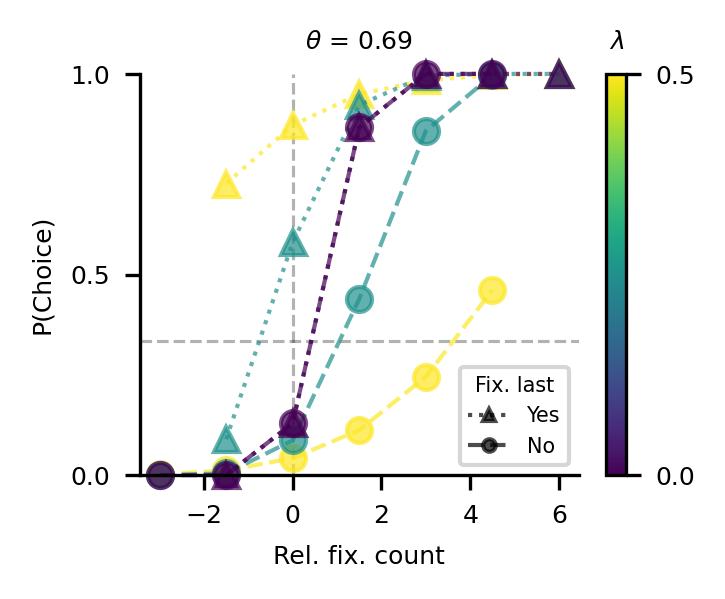

In [376]:
fig, ax = plt.subplots(dpi=300, figsize=cm2inch(6, 4.5))

ax = plot_predictions_lambda(
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    theta=theta,
    lam_min=0,
    lam_max=0.5,
    n_lam_values=3,
    ax=ax,
)

## No gaze discount: $\theta$ = 1

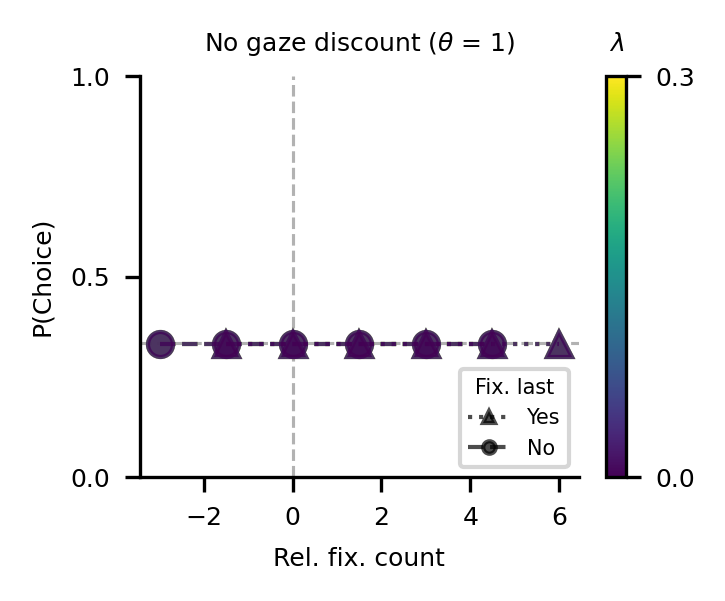

In [377]:
fig, ax = plt.subplots(dpi=300, figsize=cm2inch(6, 4.5))

ax = plot_predictions_lambda(
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    theta=1,
    lam_min=0,
    lam_max=0.3,
    n_lam_values=3,
    ax=ax,
)

ax.set_title(r"No gaze discount ($\theta$ = 1)");

## Put these together

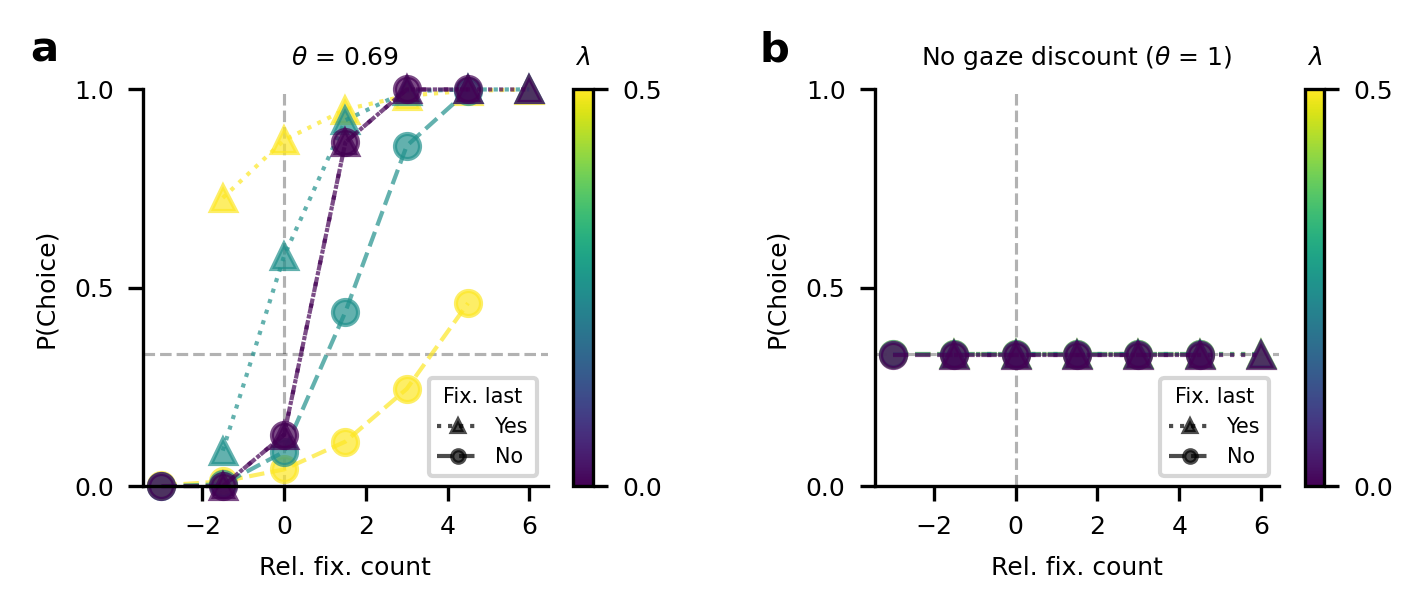

In [378]:
fig, axs = plt.subplots(1, 2, dpi=300, figsize=cm2inch(12, 5))

for ax, theta in zip(axs, [theta, 1]):
    ax = plot_predictions_lambda(
        alpha=alpha,
        beta=6.81,
        gamma=gamma,
        theta=theta,
        lam_min=0,
        lam_max=0.5,
        n_lam_values=3,
        ax=ax,
    )

axs[1].set_title(r"No gaze discount ($\theta$ = 1)")

fig.tight_layout(w_pad=4)

# Label panels
for ax, label in zip(axs.ravel(), list("ab")):
    ax.text(
        -0.21,
        1.15,
        label,
        size=10,
        fontweight="bold",
        va="top",
        ha="right",
        transform=ax.transAxes,
    )

plt.savefig(join("..", "figures", "S_gla-leak-discount-interaction.pdf"))
plt.savefig(join("..", "figures", "S_gla-leak-discount-interaction.tiff"))